In [9]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def handle_tied_predictions(probabilities, jitter_scale=1e-8):
    """
    Handle tied predictions by adding small random noise
    Returns adjusted probabilities for the entire dataset
    """
    adjusted_probs = probabilities.copy()
    
    # Find predictions that are exactly 1.0 (or any problematic constant)
    tied_mask = (probabilities == 1.0)
    
    if np.any(tied_mask):
        # Add small random noise only to tied predictions
        n_tied = np.sum(tied_mask)
        jitter = np.random.uniform(0, jitter_scale, n_tied)
        adjusted_probs[tied_mask] = probabilities[tied_mask] - jitter
    
    return adjusted_probs

In [21]:
def make_inflammation_curve(prediction,
                            rnaseq,
                            gwas,
                            intergation):
    
    df_predictions = pd.read_csv(prediction, sep='\t')
    df_integrated = pd.read_csv(intergation, sep='\t')
    df_rna_seq = pd.read_csv(rnaseq, sep='\t')[['protein','pval']]
    df_rna_seq['pval'] = handle_tied_predictions(df_rna_seq['pval'].astype(float))
    
    # df_rna_seq = df_rna_seq[df_rna_seq['pval'] < 1]
    
    df_gwas = pd.read_csv(gwas, sep='\t')[['protein', 'pval']]
    
    df_integrated.columns = ['protein','predicted_score']
    df_integrated = df_integrated.merge(df_predictions[['protein','true_label']], on='protein', how='right')
    df_integrated['predicted_score'] = df_integrated['predicted_score'].fillna(1)
    df_integrated['predicted_score'] = -df_integrated['predicted_score'].astype(float)
    # df_integrated = df_integrated.dropna()
    
    # df_gwas['pval'] = -df_gwas['pval'].astype(float)
    df_gwas = df_gwas.merge(df_predictions[['protein','true_label']], left_on='protein', right_on='protein', how='right')
    df_gwas['pval'] = df_gwas['pval'].fillna(1)
    df_gwas['pval'] = -df_gwas['pval'].astype(float)
    # df_gwas = df_gwas.dropna()
    
    # df_rna_seq['pval'] = -df_rna_seq['pval'].astype(float)
    df_rna_seq = df_rna_seq.merge(df_predictions[['protein','true_label']], left_on='protein', right_on='protein', how='right')
    df_rna_seq['pval'] = df_rna_seq['pval'].fillna(1)
    df_rna_seq['pval'] = -df_rna_seq['pval'].astype(float)
    # df_rna_seq = df_rna_seq.dropna()
    
    # 
    
    
    return df_predictions, df_rna_seq, df_gwas, df_integrated

In [24]:
np.random.seed(42)

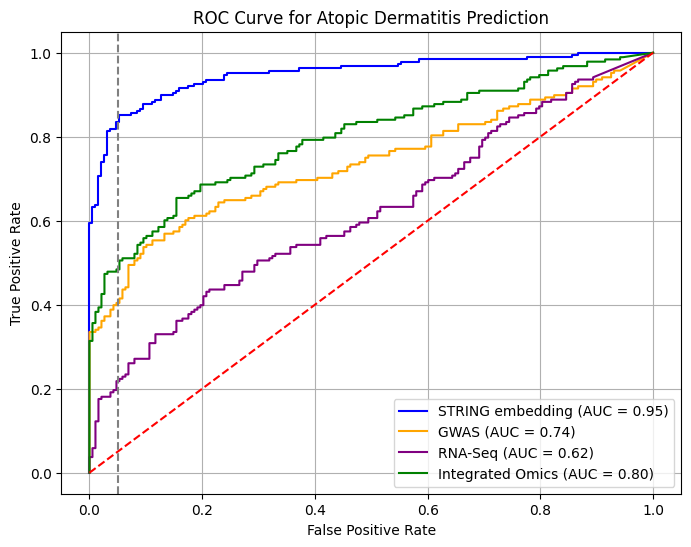

In [25]:
plt.figure(figsize=(8, 6))

df_predictions, df_rna_seq, df_gwas, df_integrated = make_inflammation_curve(
    prediction='../results/test_results/atopic_dermatitis/atopic_dermatitis_test_prediction_results.tsv',
    rnaseq='../data/train/atopic_dermatitis.rnaseq.gse121212.tsv',
    gwas='../data/train/atopic_dermatitis.gwas.gcst90244788.tsv',
    intergation='../data/train/atopic_dermatitis.integrated.tsv'
)

# predicted 
fpr, tpr, thresholds = roc_curve(df_predictions['true_label'], df_predictions['predicted_score'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label='STRING embedding (AUC = {:.2f})'.format(roc_auc))
# gwas
fpr_gwas, tpr_gwas, thresholds_gwas = roc_curve(df_gwas['true_label'], df_gwas['pval'])
roc_auc_gwas = auc(fpr_gwas, tpr_gwas)
plt.plot(fpr_gwas, tpr_gwas, color='orange', label='GWAS (AUC = {:.2f})'.format(roc_auc_gwas))
# rna
fpr_rna_seq, tpr_rna_seq, thresholds_rna_seq = roc_curve(df_rna_seq['true_label'], df_rna_seq['pval'])
roc_auc_rna_seq = auc(fpr_rna_seq, tpr_rna_seq)
plt.plot(fpr_rna_seq, tpr_rna_seq, color='purple', label='RNA-Seq (AUC = {:.2f})'.format(roc_auc_rna_seq))
# integrated
fpr_integrated, tpr_integrated, thresholds_integrated = roc_curve(df_integrated['true_label'], df_integrated['predicted_score'])
roc_auc_integrated = auc(fpr_integrated, tpr_integrated)
plt.plot(fpr_integrated, tpr_integrated, color='green', label='Integrated Omics (AUC = {:.2f})'.format(roc_auc_integrated))

plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# vertical line at x=0.05
plt.axvline(x=0.05, color='gray', linestyle='--',)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Atopic Dermatitis Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

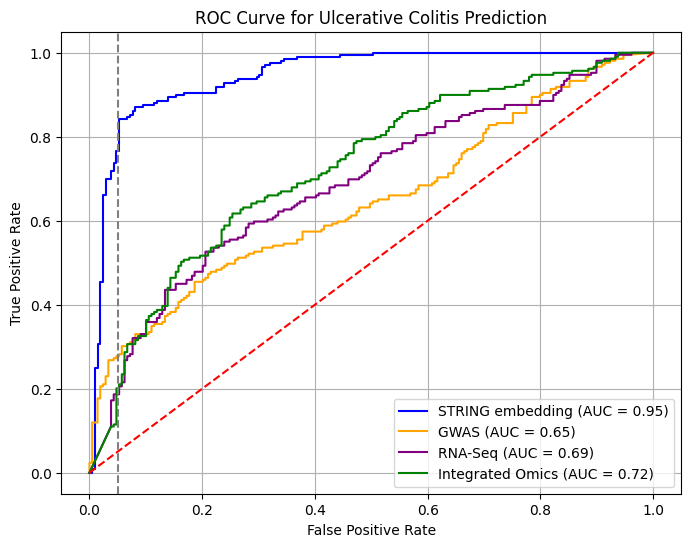

In [26]:
plt.figure(figsize=(8, 6))

df_predictions, df_rna_seq, df_gwas, df_integrated = make_inflammation_curve(
    prediction='../results/test_results/ulcerative_colitis/ulcerative_colitis_test_prediction_results.tsv',
    rnaseq='../data/train/ulcerative_colitis.rnaseq.integrated.tsv',
    gwas='../data/train/ulcerative_colitis.gwas.integrated.tsv',
    intergation='../data/train/ulcerative_colitis.integrated.tsv'
)

# predicted 
fpr, tpr, thresholds = roc_curve(df_predictions['true_label'], df_predictions['predicted_score'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label='STRING embedding (AUC = {:.2f})'.format(roc_auc))
# gwas
fpr_gwas, tpr_gwas, thresholds_gwas = roc_curve(df_gwas['true_label'], df_gwas['pval'])
roc_auc_gwas = auc(fpr_gwas, tpr_gwas)
plt.plot(fpr_gwas, tpr_gwas, color='orange', label='GWAS (AUC = {:.2f})'.format(roc_auc_gwas))
# rna
fpr_rna_seq, tpr_rna_seq, thresholds_rna_seq = roc_curve(df_rna_seq['true_label'], df_rna_seq['pval'])
roc_auc_rna_seq = auc(fpr_rna_seq, tpr_rna_seq)
plt.plot(fpr_rna_seq, tpr_rna_seq, color='purple', label='RNA-Seq (AUC = {:.2f})'.format(roc_auc_rna_seq))
# integrated
fpr_integrated, tpr_integrated, thresholds_integrated = roc_curve(df_integrated['true_label'], df_integrated['predicted_score'])
roc_auc_integrated = auc(fpr_integrated, tpr_integrated)
plt.plot(fpr_integrated, tpr_integrated, color='green', label='Integrated Omics (AUC = {:.2f})'.format(roc_auc_integrated))

plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# vertical line at x=0.05
plt.axvline(x=0.05, color='gray', linestyle='--',)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ulcerative Colitis Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

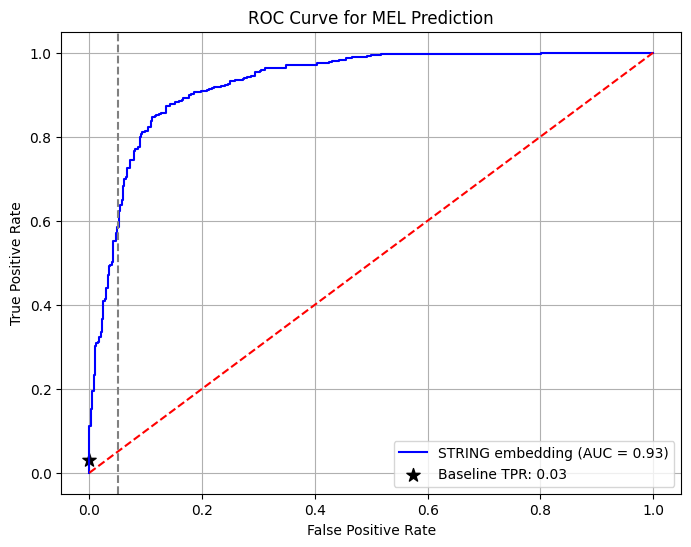

In [17]:
df_predictions = pd.read_csv('../results/test_results/MEL/MEL_test_prediction_results.tsv', sep='\t')
training_proteins = open('../data/train/MEL.mutations.intogen.txt').read().splitlines()
pos_proteins = df_predictions[df_predictions['true_label'] == 1]['protein'].tolist()
baseline_tpr = len(set(pos_proteins) & set(training_proteins)) / len(pos_proteins)

fpr, tpr, thresholds = roc_curve(df_predictions['true_label'], df_predictions['predicted_score'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='STRING embedding (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.axvline(x=0.05, color='gray', linestyle='--',)  
# add the baseline as a star
plt.scatter(0.0, baseline_tpr, color='black', marker='*', s=100, label='Baseline TPR: {:.2f}'.format(baseline_tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MEL Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

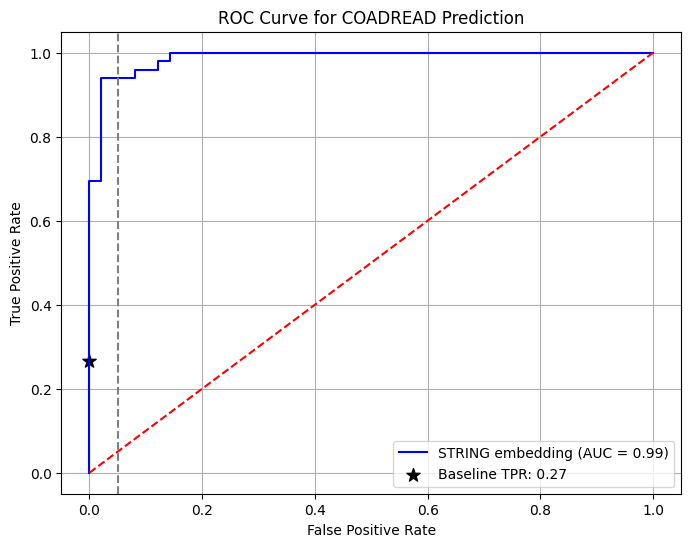

In [18]:
df_predictions = pd.read_csv('../results/test_results/COADREAD/COADREAD_test_prediction_results.tsv', sep='\t')
training_proteins = open('../data/train/COADREAD.mutations.intogen.txt').read().splitlines()
pos_proteins = df_predictions[df_predictions['true_label'] == 1]['protein'].tolist()
baseline_tpr = len(set(pos_proteins) & set(training_proteins)) / len(pos_proteins)

fpr, tpr, thresholds = roc_curve(df_predictions['true_label'], df_predictions['predicted_score'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='STRING embedding (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.axvline(x=0.05, color='gray', linestyle='--',)  
# add the baseline as a star
plt.scatter(0.0, baseline_tpr, color='black', marker='*', s=100, label='Baseline TPR: {:.2f}'.format(baseline_tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for COADREAD Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

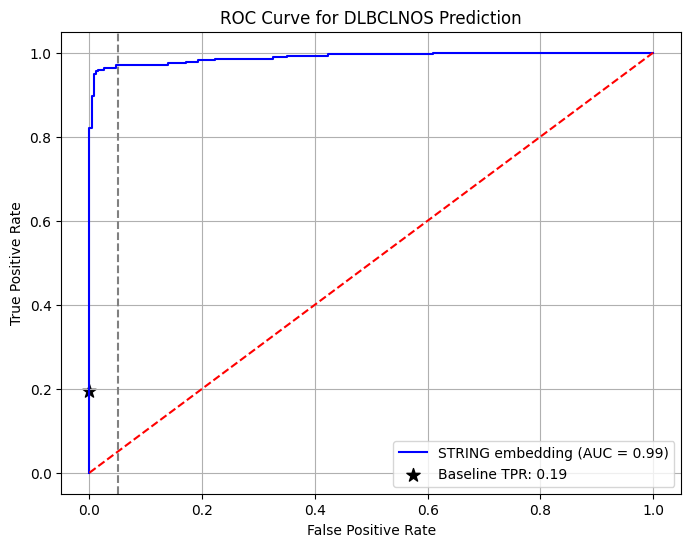

In [19]:
df_predictions = pd.read_csv('../results/test_results/DLBCLNOS/DLBCLNOS_test_prediction_results.tsv', sep='\t')
training_proteins = open('../data/train/DLBCLNOS.mutations.intogen.txt').read().splitlines()
pos_proteins = df_predictions[df_predictions['true_label'] == 1]['protein'].tolist()
baseline_tpr = len(set(pos_proteins) & set(training_proteins)) / len(pos_proteins)

fpr, tpr, thresholds = roc_curve(df_predictions['true_label'], df_predictions['predicted_score'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='STRING embedding (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.axvline(x=0.05, color='gray', linestyle='--',)  
# add the baseline as a star
plt.scatter(0.0, baseline_tpr, color='black', marker='*', s=100, label='Baseline TPR: {:.2f}'.format(baseline_tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DLBCLNOS Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

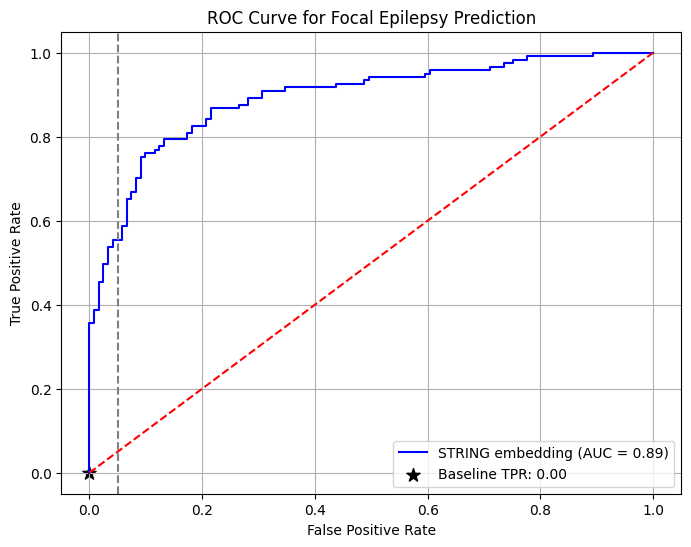

In [20]:
df_predictions = pd.read_csv('../results/test_results/focal_epilepsy/focal_epilepsy_test_prediction_results.tsv', sep='\t')
training_proteins = open('../data/train/focal_epilepsy.rnaseq.kjaer_guelfi_consensus.txt').read().splitlines()
pos_proteins = df_predictions[df_predictions['true_label'] == 1]['protein'].tolist()
baseline_tpr = len(set(pos_proteins) & set(training_proteins)) / len(pos_proteins)

fpr, tpr, thresholds = roc_curve(df_predictions['true_label'], df_predictions['predicted_score'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='STRING embedding (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.axvline(x=0.05, color='gray', linestyle='--',)  
# add the baseline as a star
plt.scatter(0.0, baseline_tpr, color='black', marker='*', s=100, label='Baseline TPR: {:.2f}'.format(baseline_tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Focal Epilepsy Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

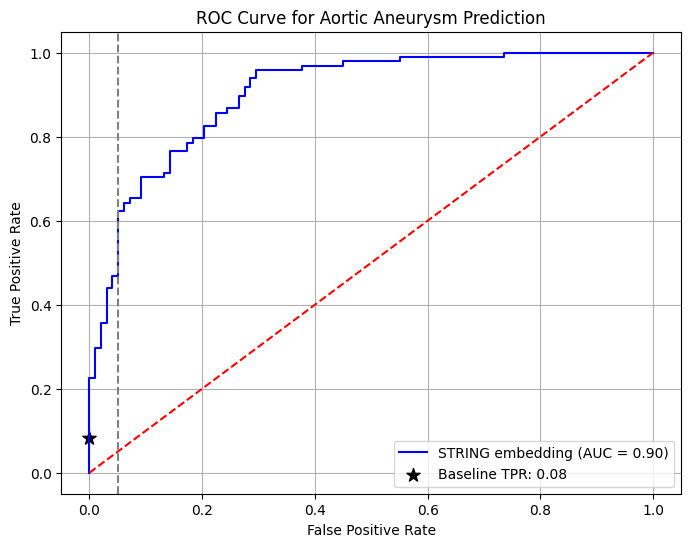

In [21]:
df_predictions = pd.read_csv('../results/test_results/aortic_aneurysm/aortic_aneurysm_test_prediction_results.tsv', sep='\t')
training_proteins = open('../data/train/aortic_aneurysm.olink.tsv').read().splitlines()
pos_proteins = df_predictions[df_predictions['true_label'] == 1]['protein'].tolist()
baseline_tpr = len(set(pos_proteins) & set(training_proteins)) / len(pos_proteins)

fpr, tpr, thresholds = roc_curve(df_predictions['true_label'], df_predictions['predicted_score'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='STRING embedding (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.axvline(x=0.05, color='gray', linestyle='--',)  
# add the baseline as a star
plt.scatter(0.0, baseline_tpr, color='black', marker='*', s=100, label='Baseline TPR: {:.2f}'.format(baseline_tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Aortic Aneurysm Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [22]:
df_heatmap = [
    {
        'disease': 'Atopic Dermatitis',
        'STRING embedding': 0.95,
        'GWAS': 0.75,
        'RNA-Seq': 0.63,
        'Integrated Omics': 0.80
    },
    {
        'disease': 'Ulcerative Colitis',
        'STRING embedding': 0.95,
        'GWAS': 0.63,
        'RNA-Seq': 0.69,
        'Integrated Omics': 0.72
    },
    {
        'disease': 'MEL',
        'STRING embedding': 0.93,
        'Baseline TPR': 0.03,
    },
    {
        'disease': 'COADREAD',
        'STRING embedding': 0.99,
        'Baseline TPR': 0.27,
    },
    {
        'disease': 'DLBCLNOS',
        'STRING embedding': 0.99,
        'Baseline TPR': 0.19,
    },
    {
        'disease': 'Focal Epilepsy',
        'STRING embedding': 0.89,
        'Baseline TPR': 0.00,
    },
    {
        'disease': 'Aortic Aneurysm',
        'STRING embedding': 0.90,
        'Baseline TPR': 0.08,
    }
]
df_heatmap = pd.DataFrame(df_heatmap)

In [33]:
df_heatmap

,disease,STRING embedding,GWAS,RNA-Seq,Integrated Omics,Baseline TPR
0,Atopic Dermatitis,0.95,0.75,0.63,0.80,NaN
1,Ulcerative Colitis,0.95,0.63,0.69,0.72,NaN
2,MEL,0.93,NaN,NaN,NaN,0.03
3,COADREAD,0.99,NaN,NaN,NaN,0.27
4,DLBCLNOS,0.99,NaN,NaN,NaN,0.19
5,Focal Epilepsy,0.89,NaN,NaN,NaN,0.00
6,Aortic Aneurysm,0.90,NaN,NaN,NaN,0.08


In [36]:
df_heatmap[df_heatmap['disease'].isin(['Atopic Dermatitis','Ulcerative Colitis'])].dropna(axis=1)

,disease,STRING embedding,GWAS,RNA-Seq,Integrated Omics
0,Atopic Dermatitis,0.95,0.75,0.63,0.80
1,Ulcerative Colitis,0.95,0.63,0.69,0.72


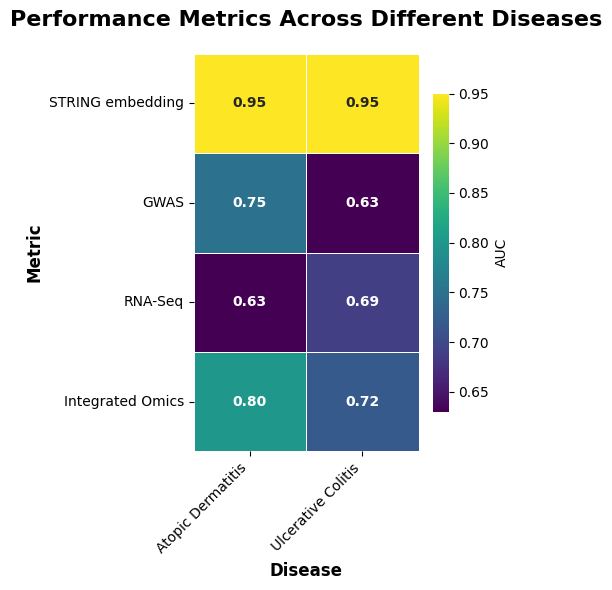

In [55]:
# Import additional libraries for better styling
import seaborn as sns
import numpy as np

# Create a more sophisticated heatmap
plt.figure(figsize=(5, 6))

# Prepare the data for heatmap
heatmap_data = df_heatmap[df_heatmap['disease'].isin(['Atopic Dermatitis','Ulcerative Colitis'])].dropna(axis=1).set_index('disease').T

# Create a mask for missing values to handle them properly
mask = heatmap_data.isnull()

# Use seaborn for a more professional heatmap
sns.heatmap(heatmap_data, 
            annot=True,  # Show values in cells
            fmt='.2f',   # Format numbers to 2 decimal places
            cmap='viridis',  # Use a more sophisticated colormap
            cbar_kws={'label': 'AUC', 'shrink': 0.8},
            linewidths=0.5,  # Add lines between cells
            linecolor='white',
            square=False,  # Allow rectangular cells
            mask=mask,  # Mask missing values
            annot_kws={'size': 10, 'weight': 'bold'},  # Style the annotations
            )

# Customize the plot
plt.title('Performance Metrics Across Different Diseases', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Disease', fontsize=12, fontweight='bold')
plt.ylabel('Metric', fontsize=12, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add a subtle grid
plt.grid(False)  # Turn off default grid since seaborn handles this

plt.show()

In [40]:
df_heatmap[~df_heatmap['disease'].isin(['Atopic Dermatitis','Ulcerative Colitis'])].dropna(axis=1)

,disease,STRING embedding,Baseline TPR
2,MEL,0.93,0.03
3,COADREAD,0.99,0.27
4,DLBCLNOS,0.99,0.19
5,Focal Epilepsy,0.89,0.00
6,Aortic Aneurysm,0.90,0.08


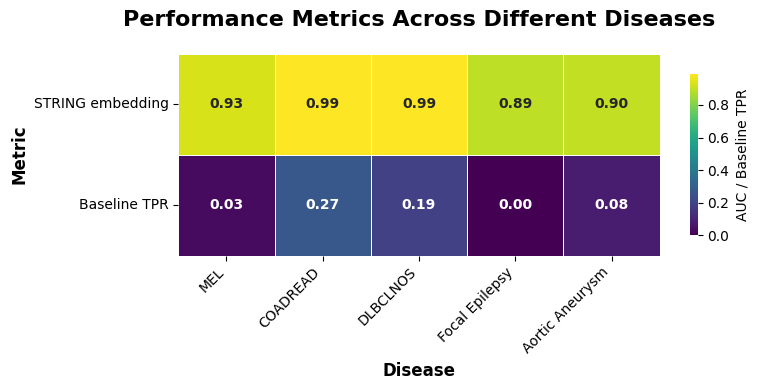

In [51]:
# Create a more sophisticated heatmap
plt.figure(figsize=(8, 4))

# Prepare the data for heatmap
heatmap_data = df_heatmap[~df_heatmap['disease'].isin(['Atopic Dermatitis','Ulcerative Colitis'])].dropna(axis=1).set_index('disease').T

# Create a mask for missing values to handle them properly
mask = heatmap_data.isnull()

# Use seaborn for a more professional heatmap
sns.heatmap(heatmap_data, 
            annot=True,  # Show values in cells
            fmt='.2f',   # Format numbers to 2 decimal places
            cmap='viridis',  # Use a more sophisticated colormap
            cbar_kws={'label': 'AUC / Baseline TPR', 'shrink': 0.8},
            linewidths=0.5,  # Add lines between cells
            linecolor='white',
            square=False,  # Allow rectangular cells
            mask=mask,  # Mask missing values
            annot_kws={'size': 10, 'weight': 'bold'},  # Style the annotations
            )

# Customize the plot
plt.title('Performance Metrics Across Different Diseases', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Disease', fontsize=12, fontweight='bold')
plt.ylabel('Metric', fontsize=12, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add a subtle grid
plt.grid(False)  # Turn off default grid since seaborn handles this

plt.show()

<Figure size 1400x800 with 0 Axes>

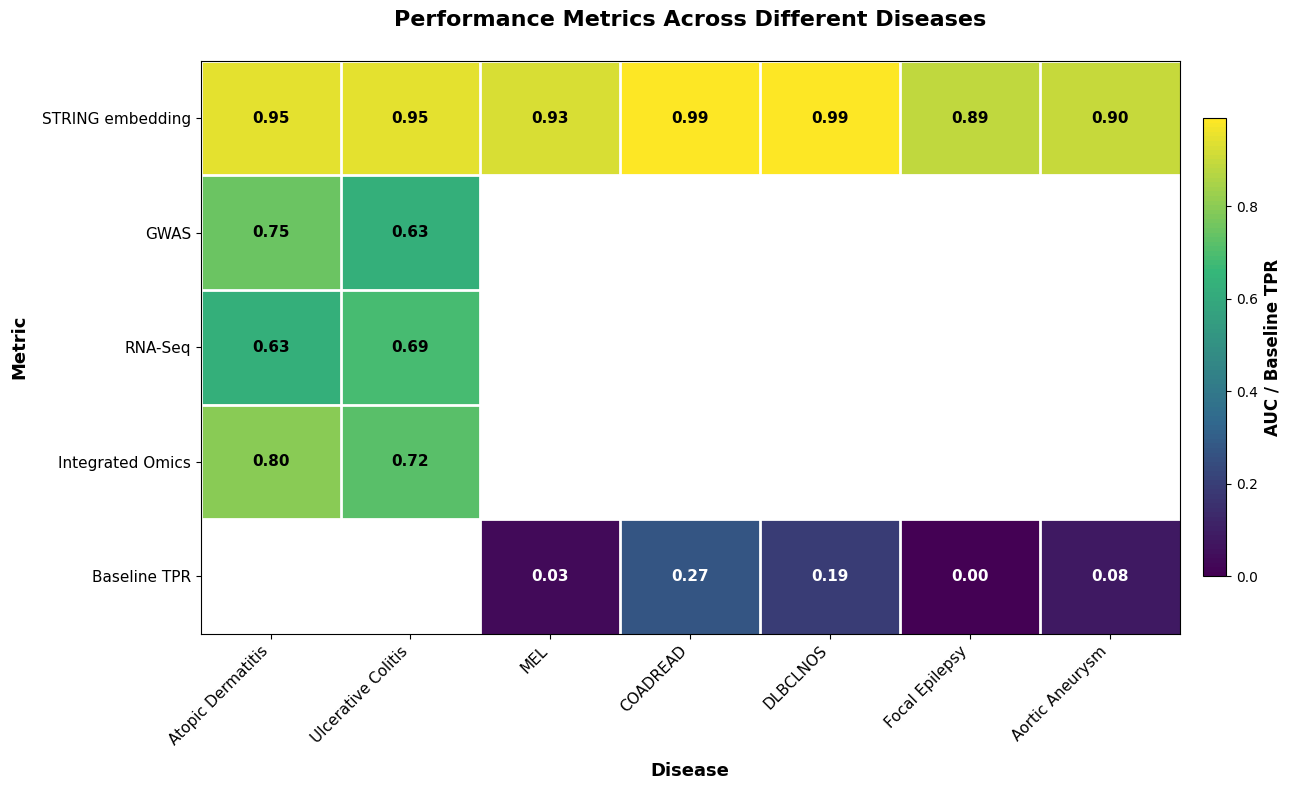

In [32]:
from matplotlib.colors import LinearSegmentedColormap

# Alternative version with matplotlib and custom styling
plt.figure(figsize=(14, 8))

# Create subplot for better control
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data
heatmap_data = df_heatmap.set_index('disease').T

# Create custom colormap

colors = ['#440154', '#31688e', '#35b779', '#fde725']  # Viridis-like colors
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Create the heatmap
im = ax.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest')

# Add text annotations
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        value = heatmap_data.iloc[i, j]
        if not pd.isna(value):
            text_color = 'white' if value < 0.5 else 'black'
            ax.text(j, i, f'{value:.2f}', 
                   ha='center', va='center', 
                   fontsize=11, fontweight='bold',
                   color=text_color)

# Customize axes
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=11)
ax.set_yticklabels(heatmap_data.index, fontsize=11)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label('AUC / Baseline TPR', fontsize=12, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Style the plot
ax.set_title('Performance Metrics Across Different Diseases', 
            fontsize=16, fontweight='bold', pad=25)
ax.set_xlabel('Disease', fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel('Metric', fontsize=13, fontweight='bold', labelpad=10)

# Add subtle grid lines
ax.set_xticks(np.arange(len(heatmap_data.columns)) - 0.5, minor=True)
ax.set_yticks(np.arange(len(heatmap_data.index)) - 0.5, minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=2)

# Remove ticks on minor grid
ax.tick_params(which='minor', size=0)

# Set background color
ax.set_facecolor('white')

plt.tight_layout()
plt.show()